# В этом семинаре разберемся: 
+ как подготавливать данные  
+ как составлять нейросети 
+ как работает автоградиент
+ как собственно тренировать нейросети в PyTorch (наконец-то)

# 1. Готовим данные

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Normalize, Lambda
import matplotlib.pyplot as plt

In [2]:
training_data = datasets.FashionMNIST(
    root="../data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="../data",
    train=False,
    download=True,
    transform=ToTensor()
)

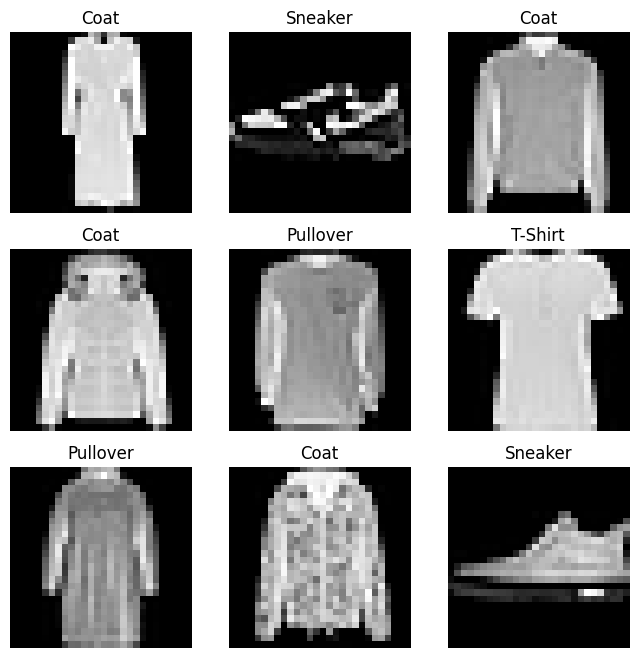

In [3]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Создаем собственный датасет

In [5]:
import pandas as pd
import numpy as np


class CustomImageDataset(Dataset):
    def __init__(self, data_file, transform=None, target_transform=None):
        self.data = pd.read_csv(data_file)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        image = self.data.iloc[idx, 1:].values.reshape(28, 28).astype(np.uint8)
        label = self.data.iloc[idx, 0]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [9]:
train = CustomImageDataset('../data/fashion-mnist_train.txt', 
                           transform=ToTensor(), 
                           target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)))
test = CustomImageDataset('../data/fashion-mnist_test.txt', 
                          transform=ToTensor(),
                          target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)))

## Подключаем даталоадеры

In [15]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test, batch_size=64, shuffle=True)

# 2. Собираем нейросеть

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [17]:
from torch import nn


class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [18]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [19]:
X = torch.rand(1, 28, 28, device=device)
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([9])


## Детально посмотрим в слои сетки

In [21]:
input_image = torch.rand(3, 28, 28)
print(input_image.size())

torch.Size([3, 28, 28])


In [22]:
input_image

tensor([[[0.0307, 0.7775, 0.2814,  ..., 0.1890, 0.8300, 0.0031],
         [0.9757, 0.2752, 0.2085,  ..., 0.9989, 0.6498, 0.0668],
         [0.2182, 0.4046, 0.4046,  ..., 0.0793, 0.4338, 0.8980],
         ...,
         [0.6141, 0.0275, 0.4920,  ..., 0.1372, 0.3271, 0.9247],
         [0.9123, 0.6137, 0.6879,  ..., 0.1040, 0.9598, 0.7469],
         [0.5008, 0.6555, 0.1351,  ..., 0.4441, 0.5178, 0.1941]],

        [[0.1163, 0.9033, 0.9534,  ..., 0.6715, 0.3805, 0.0889],
         [0.3002, 0.7308, 0.3930,  ..., 0.4507, 0.2489, 0.9634],
         [0.1156, 0.0294, 0.8272,  ..., 0.8888, 0.2771, 0.1462],
         ...,
         [0.9917, 0.6140, 0.2660,  ..., 0.1076, 0.3776, 0.0613],
         [0.3492, 0.9419, 0.6277,  ..., 0.4775, 0.3819, 0.5785],
         [0.8097, 0.7122, 0.4001,  ..., 0.2728, 0.6019, 0.8878]],

        [[0.2112, 0.4802, 0.5555,  ..., 0.0126, 0.7767, 0.8537],
         [0.8466, 0.3322, 0.6596,  ..., 0.9781, 0.0756, 0.4855],
         [0.4117, 0.5094, 0.2675,  ..., 0.2312, 0.2881, 0.

In [23]:
flatten = nn.Flatten()
flat_image = flatten(input_image)
print(flat_image.size())

torch.Size([3, 784])


In [24]:
flat_image

tensor([[0.0307, 0.7775, 0.2814,  ..., 0.4441, 0.5178, 0.1941],
        [0.1163, 0.9033, 0.9534,  ..., 0.2728, 0.6019, 0.8878],
        [0.2112, 0.4802, 0.5555,  ..., 0.7077, 0.9436, 0.8282]])

In [25]:
layer1 = nn.Linear(in_features=28*28, out_features=20)
hidden1 = layer1(flat_image)
print(hidden1.size())

torch.Size([3, 20])


In [26]:
print(f"Before ReLU: {hidden1}\n\n")
hidden1 = nn.ReLU()(hidden1)
print(f"After ReLU: {hidden1}")

Before ReLU: tensor([[ 0.2932, -0.0984, -0.3226,  0.0247, -0.4726,  0.4342,  0.3002, -0.5174,
          0.1160, -0.1433, -0.0292,  0.1124, -0.5049, -0.1479, -0.2311,  0.2273,
         -0.2412,  0.1191,  0.1867, -0.3463],
        [ 0.3679, -0.1046, -0.2070,  0.0545, -0.0909,  0.3126,  0.3765, -0.2476,
          0.1321,  0.0142,  0.0661,  0.2675, -0.7265, -0.1047, -0.1662,  0.1878,
          0.2962,  0.3638,  0.1590, -0.2971],
        [ 0.3151,  0.2798, -0.2746,  0.5020, -0.1213,  0.4413,  0.2442,  0.0346,
          0.3693,  0.0614, -0.1005,  0.3824, -0.4965,  0.0839, -0.2596,  0.1208,
          0.2447,  0.1944,  0.0344,  0.3192]], grad_fn=<AddmmBackward0>)


After ReLU: tensor([[0.2932, 0.0000, 0.0000, 0.0247, 0.0000, 0.4342, 0.3002, 0.0000, 0.1160,
         0.0000, 0.0000, 0.1124, 0.0000, 0.0000, 0.0000, 0.2273, 0.0000, 0.1191,
         0.1867, 0.0000],
        [0.3679, 0.0000, 0.0000, 0.0545, 0.0000, 0.3126, 0.3765, 0.0000, 0.1321,
         0.0142, 0.0661, 0.2675, 0.0000, 0.0000, 0.00

In [27]:
seq_modules = nn.Sequential(
    flatten,
    layer1,
    nn.ReLU(),
    nn.Linear(20, 10)
)
input_image = torch.rand(3,28,28)
logits = seq_modules(input_image)

In [28]:
logits.shape

torch.Size([3, 10])

In [29]:
logits

tensor([[-0.1926, -0.1158,  0.0246, -0.0134,  0.0418, -0.0285, -0.0266,  0.1888,
          0.0450, -0.1377],
        [-0.1810, -0.2088, -0.0397, -0.1216,  0.0742, -0.0040, -0.1119,  0.2674,
          0.1363,  0.0500],
        [-0.0048, -0.2289, -0.0337, -0.2035, -0.0929,  0.1043, -0.0249,  0.2144,
          0.1433, -0.0150]], grad_fn=<AddmmBackward0>)

In [30]:
softmax = nn.Softmax(dim=1)
pred_probab = softmax(logits)

In [31]:
pred_probab.argmax(dim=1)

tensor([7, 7, 7])

In [32]:
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure: NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values : tensor([[ 0.0213, -0.0352,  0.0012,  ..., -0.0318, -0.0247,  0.0154],
        [ 0.0057, -0.0055,  0.0172,  ...,  0.0327,  0.0191, -0.0114]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values : tensor([-0.0263,  0.0248], grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values : tensor([[-0.0018, -0.0030,  0.0170,  ..., -0.0137, -0.0187, -0.0266],
        [-0.0372,  0.0074,  0.0236,  ...,  0.0302, -0.0249,  0.0008]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.bias | 

# 3. Смотрим автоградиент

![](https://pytorch.org/tutorials/_images/comp-graph.png "граф вычислений")

In [33]:
import torch

x = torch.ones(5)  # input tensor
y = torch.zeros(3)  # expected output
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w) + b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

In [34]:
print(f"Gradient function for z = {z.grad_fn}")
print(f"Gradient function for loss = {loss.grad_fn}")

Gradient function for z = <AddBackward0 object at 0x000001FB752B00A0>
Gradient function for loss = <BinaryCrossEntropyWithLogitsBackward0 object at 0x000001FB4B40AE80>


In [35]:
print(w.grad)
print(b.grad)

None
None


In [36]:
loss.backward()
print(w.grad)
print(b.grad)

tensor([[0.0083, 0.1030, 0.0757],
        [0.0083, 0.1030, 0.0757],
        [0.0083, 0.1030, 0.0757],
        [0.0083, 0.1030, 0.0757],
        [0.0083, 0.1030, 0.0757]])
tensor([0.0083, 0.1030, 0.0757])


In [37]:
z = torch.matmul(x, w) + b
print(z.requires_grad)

with torch.no_grad():
    z = torch.matmul(x, w)+b
print(z.requires_grad)

True
False


In [38]:
z = torch.matmul(x, w)+b
z_det = z.detach()
print(z_det.requires_grad)

False


In [39]:
inp = torch.eye(4, 5, requires_grad=True)
out = (inp+1).pow(2).t()
out.backward(torch.ones_like(out), retain_graph=True)
print(f"First call\n{inp.grad}")
out.backward(torch.ones_like(out), retain_graph=True)
print(f"\nSecond call\n{inp.grad}")
inp.grad.zero_()
out.backward(torch.ones_like(out), retain_graph=True)
print(f"\nCall after zeroing gradients\n{inp.grad}")

First call
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.]])

Second call
tensor([[8., 4., 4., 4., 4.],
        [4., 8., 4., 4., 4.],
        [4., 4., 8., 4., 4.],
        [4., 4., 4., 8., 4.]])

Call after zeroing gradients
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.]])


# 4. Тренировка нейросети

#### Инициализируем модель

In [40]:
model = NeuralNetwork()

#### Инициализируем параметры

In [41]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

#### Инициализируем функцию потерь

In [42]:
loss_fn = nn.CrossEntropyLoss()

#### Инициализируем оптимизатор

In [43]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

#### Описываем функции тренировки и тестирования модели

In [44]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [45]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.300316  [    0/60000]
loss: 2.279979  [ 6400/60000]
loss: 2.276014  [12800/60000]
loss: 2.261893  [19200/60000]
loss: 2.253119  [25600/60000]
loss: 2.229235  [32000/60000]
loss: 2.217911  [38400/60000]
loss: 2.212491  [44800/60000]
loss: 2.197930  [51200/60000]
loss: 2.161907  [57600/60000]
Test Error: 
 Accuracy: 40.4%, Avg loss: 2.162702 

Epoch 2
-------------------------------
loss: 2.143482  [    0/60000]
loss: 2.127630  [ 6400/60000]
loss: 2.131433  [12800/60000]
loss: 2.130873  [19200/60000]
loss: 2.078666  [25600/60000]
loss: 2.036242  [32000/60000]
loss: 2.017497  [38400/60000]
loss: 2.005004  [44800/60000]
loss: 1.896453  [51200/60000]
loss: 1.920744  [57600/60000]
Test Error: 
 Accuracy: 50.3%, Avg loss: 1.900828 

Epoch 3
-------------------------------
loss: 1.925243  [    0/60000]
loss: 1.861770  [ 6400/60000]
loss: 1.795027  [12800/60000]
loss: 1.805994  [19200/60000]
loss: 1.768101  [25600/60000]
loss: 1.663043  [32000/600